In [14]:
%load_ext autoreload
%autoreload 2

!pip install pyroomacoustics
!pip install blind_rt60

import os
import warnings
import matplotlib.pyplot as plt


import numpy as np
import pyroomacoustics as pra
from scipy.io import wavfile

from blind_rt60 import BlindRT60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.3-cp311-cp311-linux_x86_64.whl size=46837499 sha256=322892e89761ef9529ac293ed7b66281f05bc5f0e501f201332c9ca34b85d9af
  Stored in directory: /root/.cache/pip/wheels/63/45/21/e7df2e64ca3b125fd4d6da69c8a4ee46d0ad6acc1f3de6832f
Successfully built pyroomacoustics


# Load Data

In [60]:

import os
import librosa
import soundfile as sf
from scipy.io import wavfile

# Define path
path = r"/content/sample_data/26c69a72-4ffa-4b50-885c-23cfae2827f3.wav"
output_path = r"/content/sample_data/t_44k.wav"  # New file with 44.1kHz

# Load the WAV file with librosa (handles different formats)
audio, fs = librosa.load(path, sr=44100)  # Resample to 44.1kHz

# Save the resampled file
sf.write(output_path, audio, 441000)

# Read the converted file using scipy
fs_new, audio_new = wavfile.read(output_path)

print(f"Original Sample Rate: {fs}")
print(f"Converted Sample Rate: {fs_new}")
print(f"Converted file saved to: {output_path}")




path2: str = r"/content/sample_data/t_44k.wav"

# Import a mono wavfile as the source signal
fs, audio = wavfile.read(os.path.join('..', path2))

<ipython-input-60-76d172ff90b0>:11: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(path, sr=44100)  # Resample to 44.1kHz
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Original Sample Rate: 44100
Converted Sample Rate: 441000
Converted file saved to: /content/sample_data/t_44k.wav


# Room Simulation

## Create the Room

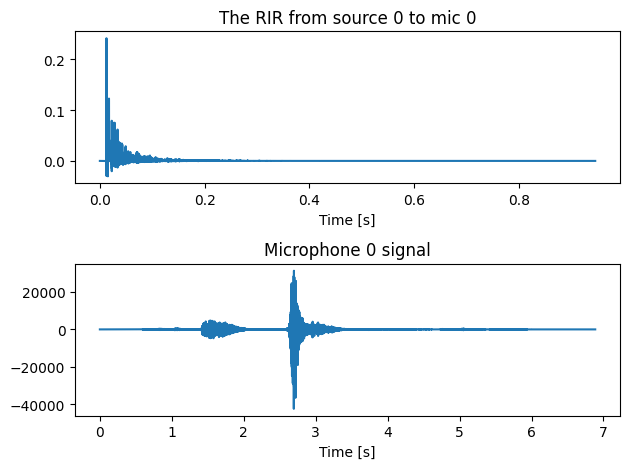

In [49]:
rt60_tgt = 0.3


# Create the room
room_dim = [10, 7.5, 3.5]  # meters
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)  # Invert Sabine's formula, ISM simulator

room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# Place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# Define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2],
]
room.add_microphone_array(mic_locs)

# Run the simulation
room.simulate()

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[0][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 0")
plt.xlabel("Time [s]")

# plot signal at microphone 0
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(room.mic_array.signals[0, :])) / room.fs, room.mic_array.signals[0, :])
plt.title("Microphone 0 signal")
plt.xlabel("Time [s]")

plt.tight_layout()

## Compute Schroeder RT60

In [50]:
rt60_schroeder = room.measure_rt60()[0, 0,...]
print(f'Schroeder RT60: {rt60_schroeder:.2f} sec')

Schroeder RT60: 0.37 sec


# Blind RT60 Measurement

Iteration 1000 / 1000; rt60 2.37 sec; tau 0.34 sec
Blind RT60: 2.37 sec


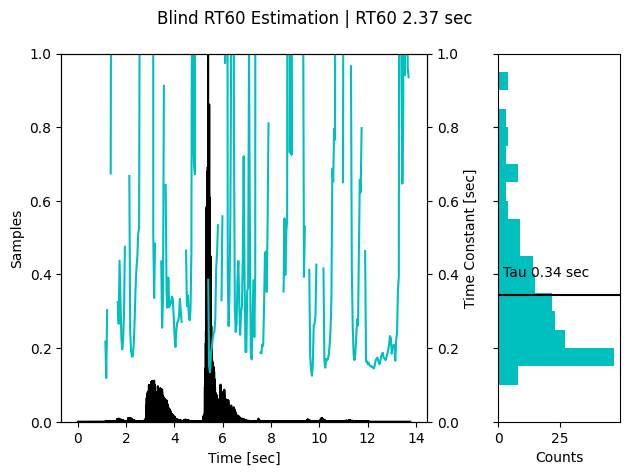

In [58]:
blind_rt60 = BlindRT60(verbose=True)
rt60_estimations = np.array([blind_rt60(room.mic_array.signals[i, ...], fs)
                             for i in range(mic_locs.shape[-1])])[0]
print(f'Blind RT60: {rt60_estimations:.2f} sec')
fig = blind_rt60.visualize(room.mic_array.signals[0, ...], fs)
fig.savefig(r'..\supplementary_material\graphs\BlindRT60.png')